#Objective
**I want to quantitatively compare the results when determining flow from the raw intensity data, and from the relative fluorescence data. I will make a contrived testing scenario where the exact flow is known and compare the approximated flow determined in both approaches.**

###Introduction and Routines
We'll start by constructing an ideal case where the flow is uniform with constant amplitude and constant background intensity. An $n \times n$ matrix with ones in the background and a point source with amplitude ten will move along the diagonal. The below function generates this dataset where a point flows linearly from the top left corner of the screen to the bottom right corner of the screen. It returns the dataset, and the exact flow. There are parameters to perturb things for comparisons in the future. Read its documentation if you would like to know more.

In [1]:
from numpy import *
set_printoptions(1)

def makeData(dims, background=1, signalAmplitude=10, noise=0):
    """
    Here we construct a cube where all three dimensions are equal 
    to dims. This is a test dataset intended to model a point flowing
    linearly from the top left corner of frame 0, point (0,0,0), to 
    the bottom right corner of the last frame, point (dims-1,dims-1,dims-1)
    
    Parameters
    ----------
    background : scalar
        Background intensity of the dataset. For now it is uniform.
    signalAmplitude : scalar
        The amplitude of the actual signal, the point moving along the
        diagonal.
    noise : scalar
        The amplitude of the noise to be added to the system. 
        
    Returns
    -------
    intensity : numpy array
        This is the sample dataset. It will be of shape (dims,dims,dims)
    yflowExact : numpy array
        This will contain the exact y components of the flow vectors. This
        will be of shape (dims-1, dims, dims)
    xflowExact : numpy array
        This will contain the exact x components of the flow vectors. This
        too will be of shape (dims-1, dims, dims)
    """
    shape = [dims]*3
    f = ones(shape)*background
    yflowExact = zeros(shape)
    for i,a in enumerate(f):
        f[i,i,i] = signalAmplitude
        yflowExact[i,i,i] = 1
    f += random.random(shape)*noise
    yflowExact = yflowExact[:-1]
    xflowExact = yflowExact.copy()
    return (f, yflowExact, xflowExact)

We know the exact flow in this case to simply be one along the diagonals (where the origin is defined in the top left corner as is generally done in computer graphics). From one frame to the next, the point moves 1 unit in the positive x direction and 1 unit in the positive y direction. So in the *makeData* routine, we also construct the exact flows for future analysis.

We'll construct a small sample dataset to demonstrate what the data looks like

In [2]:
f,fx,fy = makeData(3) # Generate a test dataset of dimension 3

The intensity data set generated from the above routine looks like so...

In [3]:
f

array([[[ 10.,   1.,   1.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.]],

       [[  1.,   1.,   1.],
        [  1.,  10.,   1.],
        [  1.,   1.,   1.]],

       [[  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [  1.,   1.,  10.]]])

And both of the exact flows have ones along the 3D diagonal...

In [4]:
fx

array([[[ 1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  0.]]])

In [5]:
fy

array([[[ 1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  0.]]])

Now we calculate the **relative fluorescence**. We will use the $n^{th}$ percentile approach, where here $n=10$.

In [6]:
f0 = percentile(f,10,0); f0 # This is obviously all 1's in this case

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

In [7]:
relF = (f-f0)/f0; relF # This looks great of course

array([[[ 9.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  9.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  9.]]])

Relative fluorescence, **in this case**, isolates the larger amplitude motion while smothering the small scale activity. This is desireable and I would say this is *"better"* than using the regular intensity data. We will see how well the flow is determined using the farneback flow algorithm and compare it against the exact flow. Below we define a simple routine, *calcFlow*, to calculate and return the flow.

In [8]:
import cv2

def calcFlow(dataset, parameters=None):
    flowParams = {'pyr_scale':0.5, 'levels':3, 'winsize':7, 'iterations':3, 'poly_n':5,
                  'poly_sigma':0.8, 'flags':cv2.OPTFLOW_FARNEBACK_GAUSSIAN}
    flowParams = parameters if parameters else flowParams
    frames, h, w = dataset.shape
    yflow = ndarray((frames-1,h,w))
    xflow = ndarray((frames-1,h,w))
    prev = dataset[0]
    for i,curr in enumerate(dataset[1:]):
        flow = cv2.calcOpticalFlowFarneback(prev, curr, **flowParams)
        yflow[i] = flow[:,:,0]
        xflow[i] = flow[:,:,1]
        prev = curr
        
    return (yflow, xflow)

Now we make a routine, *show*, to visualize the flow. It can handle any number of flow fields and allows plotting them in a grid for easier comparison. You can also look at subsets of larger slices using the **frames** parameter. **cols** controls the number of columns used in the grid to display the plots

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 

def show(dataset, xvecs, yvecs, frames=[0,None], cols=3, parameters=None):
    vecParams = {'pivot':'middle', 'angles':'xy', 'scale_units':'xy', 'color':'yellow', 'scale':1}
    vecParams = parameters if parameters else vecParams

    if dataset.ndim == 2:
        plt.figure(figsize=(10,10))
        plt.imshow(dataset, cmap='gray')
        plt.quiver(xvecs, yvecs, **vecParams)
        return
    else:
        begf, endf = frames
        endf = endf if endf else len(xvecs)
        rows = int(ceil((endf-begf)/float(cols)))
        fw = 13; fh = float(rows*fw)/cols
        plt.figure(figsize=(fw, fh))
        for i in range(begf, endf):
            plt.subplot(rows,cols,i-begf+1) 
            plt.imshow(dataset[i], cmap='gray', interpolation='nearest')
            plt.title("Flow from frame %d to frame %d" % (i,i+1))
            plt.quiver(xvecs[i], yvecs[i], **vecParams)
    plt.tight_layout()

---
###Test 1
Now we do a test case on a simple dataset of size 21

In [10]:
f,fx,fy = makeData(21)
f0 = percentile(f,10,0)
relF = (f-f0)/f0

First we calculate the flow for the regular intensity data...

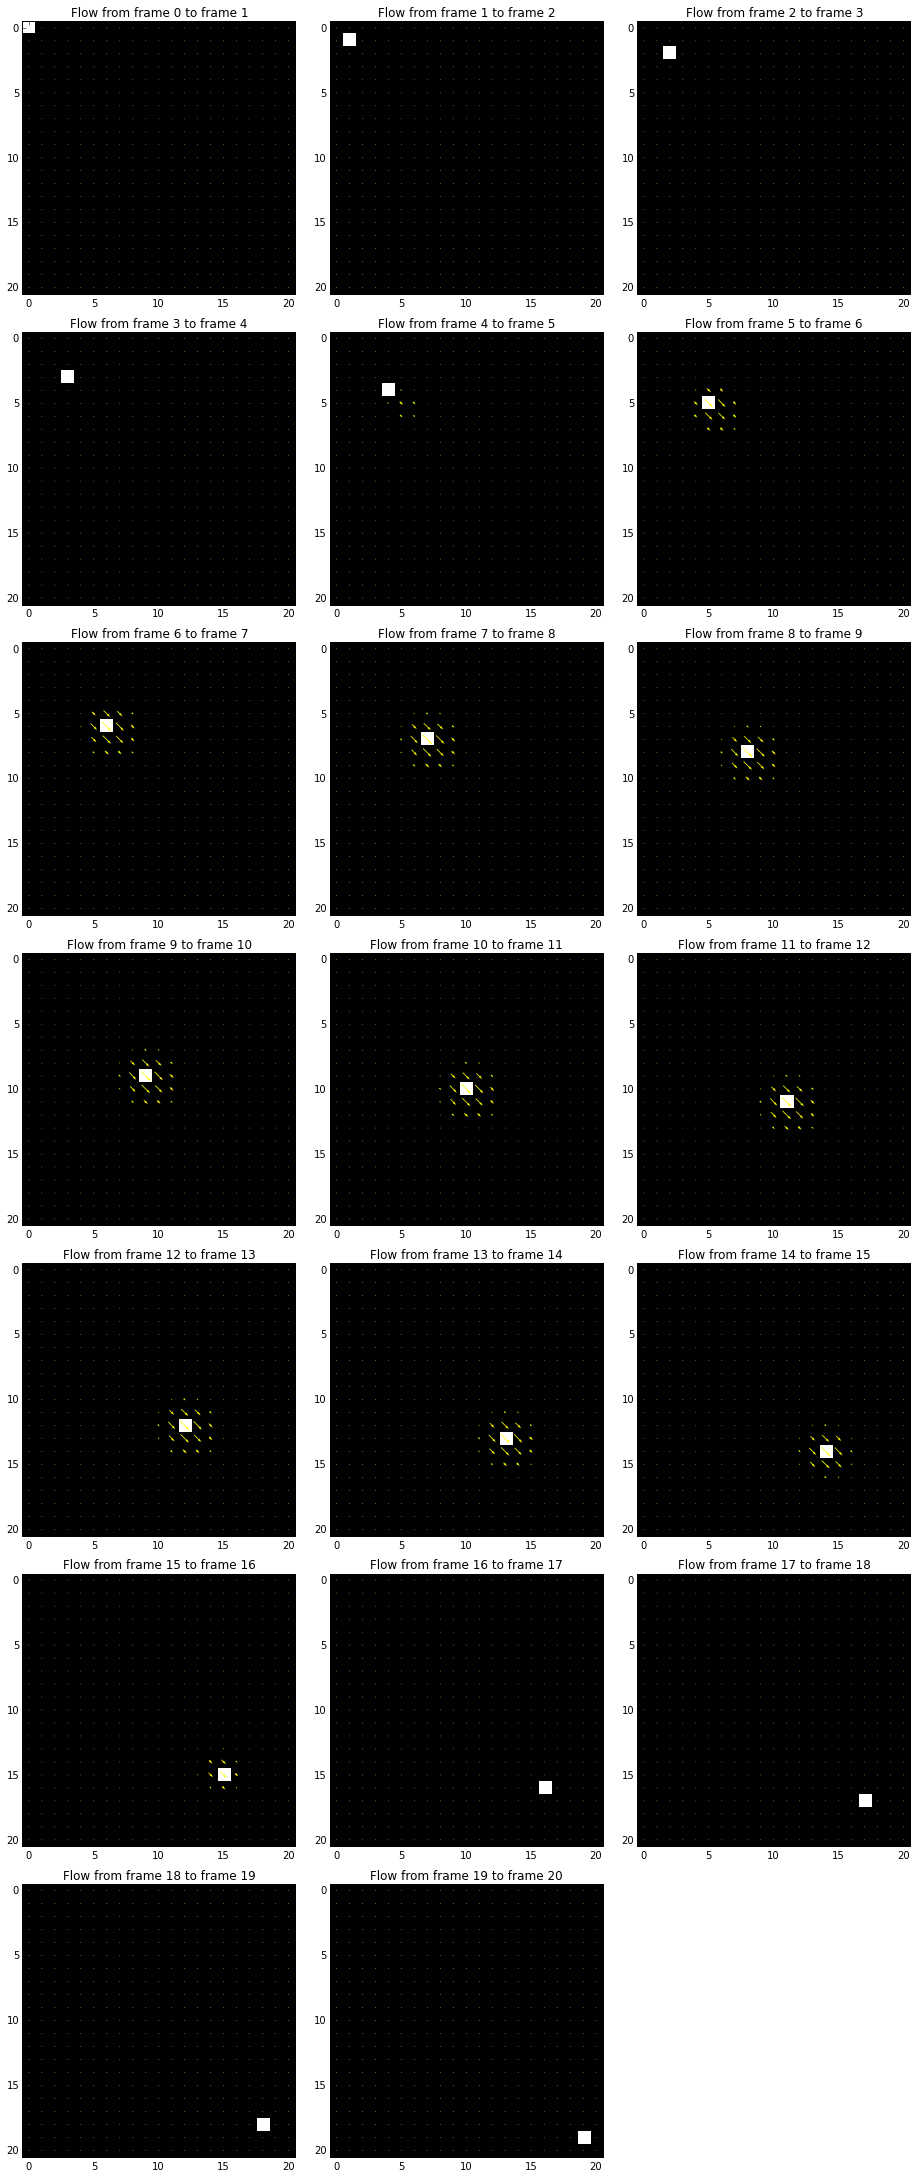

In [11]:
fy1, fx1 = calcFlow(f)
show(f, fx1, fy1)

Now we determine the flow information for the **relative fluorescence**

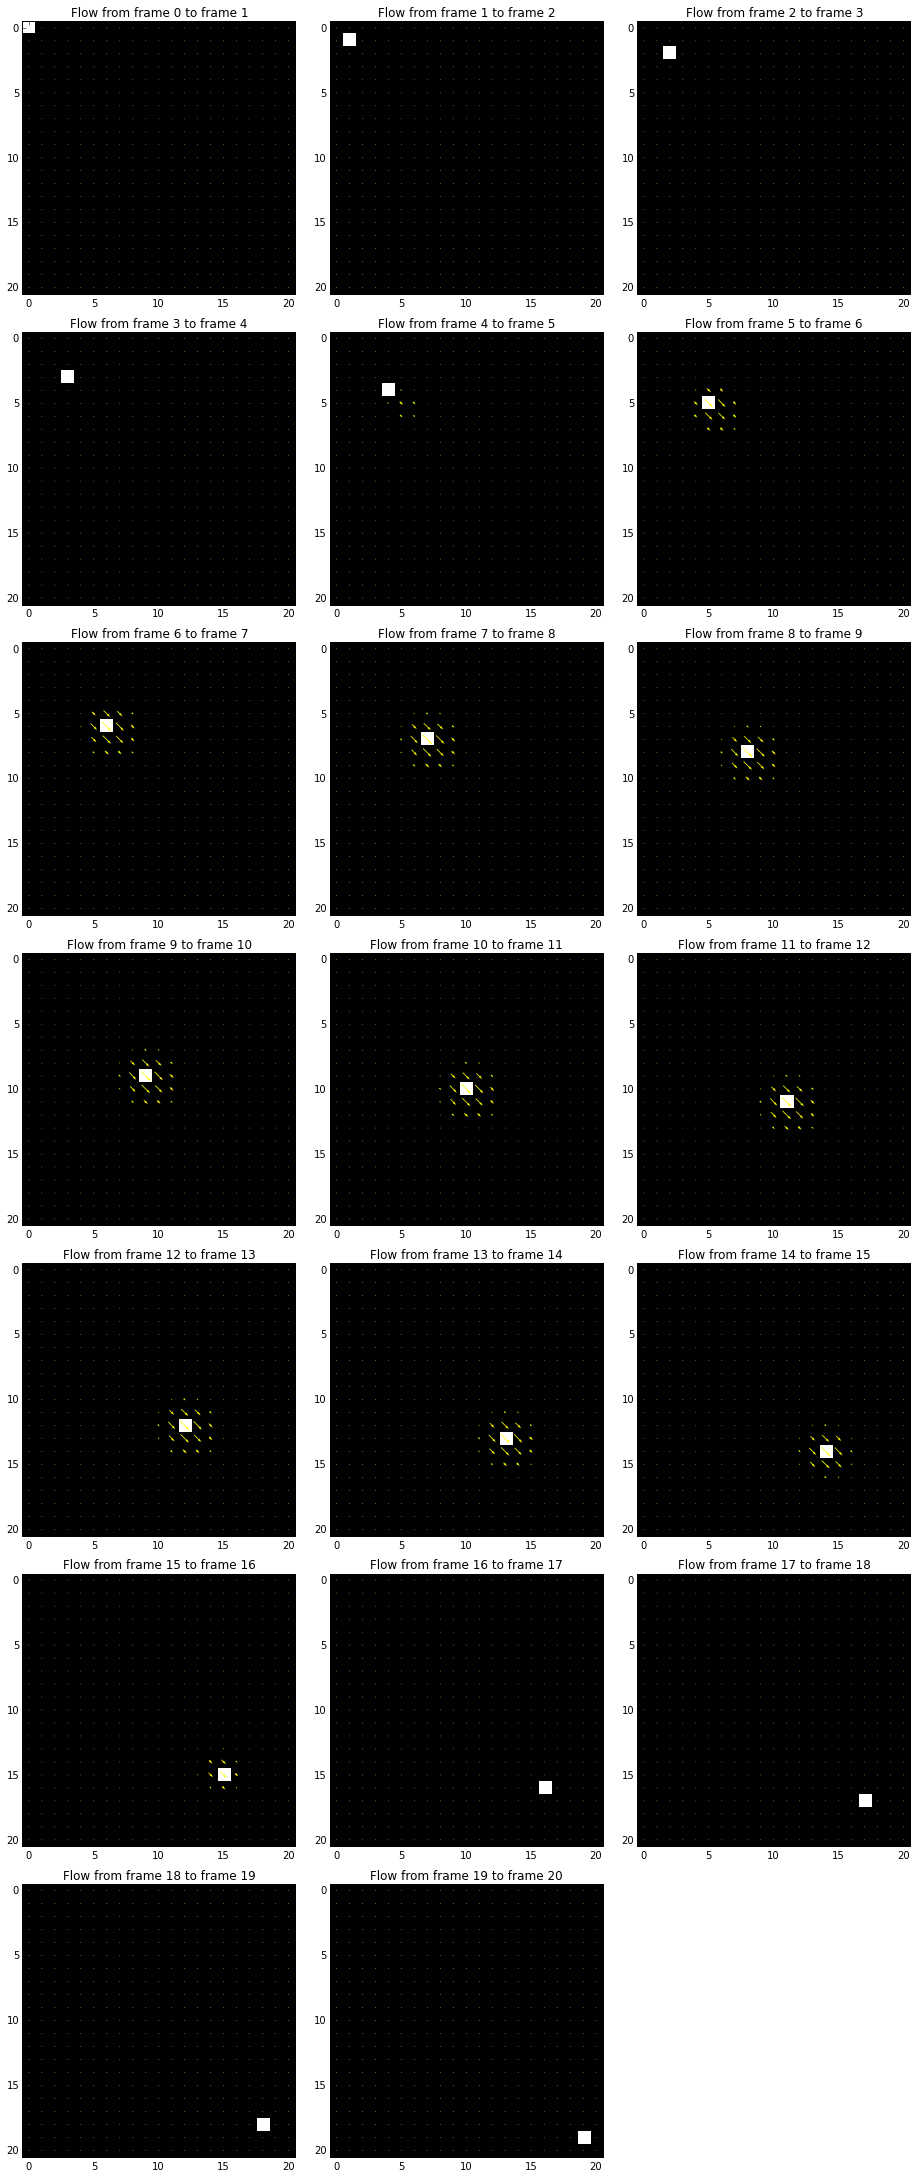

In [12]:
fy2, fx2 = calcFlow(relF)
show(relF, fx2, fy2)

Now the moment we've all be waiting for... The error analysis. 

1. First I determine the L2 norm of the difference between every respective flow vector in the entire spatial and temporal dataset. Essentially it is the point wise error between every flow vector.
2. Then I calculate the Frobenius norm of the matrix for each point in time. The Frobenius norm is simply the square root of the sum of squares of every component, sort of like an L2 norm for matrices. This produces a 1D array where every element is a single number representing the error at each time step. 
3. Finally, I take the average of these norms to get one sinlge number representing the total error or *General Accuracy* of the method on **this** dataset.

In [13]:
def error(fxTrue, fyTrue, fxApprox, fyApprox):

    trueNorms = sqrt(fxTrue**2 + fyTrue**2)
    approxNorms = sqrt(fxApprox**2 + fyApprox**2)
    maxErr = trueNorms+approxNorms
    maxErr[abs(maxErr) < 1e-12] = 1.0
    err = sqrt((fxTrue-fxApprox)**2 + (fyTrue-fyApprox)**2)/maxErr
    print "Maximum Point-wise Error = ", err.max()
    print "Minimum Point-wise Error = ", err.min()
    frob = linalg.norm(err,'fro',(1,2))
    print "Maximum Frobenius Norm = ", frob.max()
    print "Minimum Frobenius Norm = ", frob.min()
    totErr = average(frob)
    print "Total Error = ", totErr
    return totErr

Let's apply the above routine to the flow determined from the regular dataset

In [14]:
totErr1 = error(fx, fy, fx1, fy1)

Maximum Point-wise Error =  1.0
Minimum Point-wise Error =  0.0
Maximum Frobenius Norm =  12.4508231695
Minimum Frobenius Norm =  6.78232774019
Total Error =  10.7011577628


Now we do the exact same thing for the relative fluorescence flow

In [15]:
totErr2 = error(fx, fy, fx2, fy2)

Maximum Point-wise Error =  1.0
Minimum Point-wise Error =  0.0
Maximum Frobenius Norm =  12.4508231683
Minimum Frobenius Norm =  6.78232774019
Total Error =  10.7011577621


As expected having seen the data above the results are essentially identical as we can see by looking at the ratio of their total errors.

In [16]:
totErr1/totErr2

1.0000000000662506

---
###Test 2
Now we add in some noise... The signal amplitude is 10, so adding a noise amplitude of 3 gives us a SNR of 3.333

In [17]:
f,fy,fx = makeData(21, noise=3.0) # Generate a another test dataset with amplitude 3 random noise
f0 = percentile(f,10,0)
relF = (f-f0)/f0

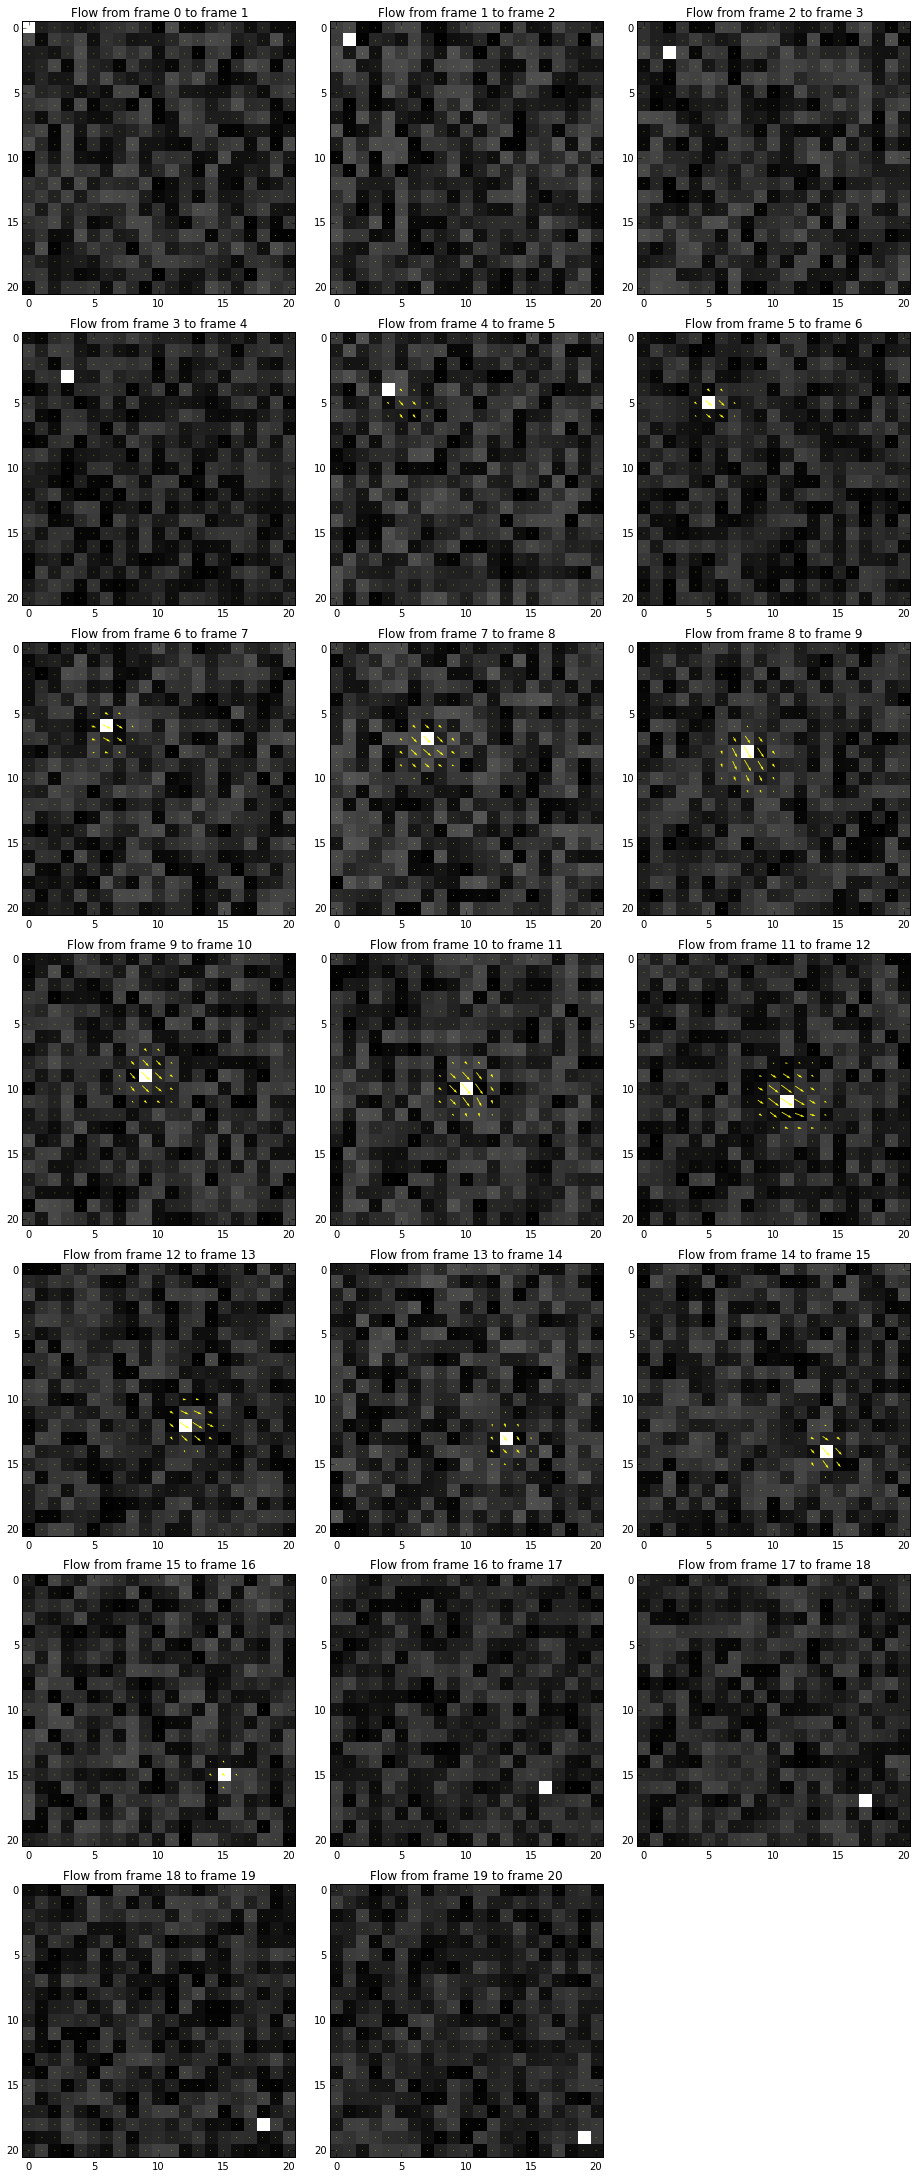

In [18]:
fy1, fx1 = calcFlow(f)
show(f, fx1, fy1)

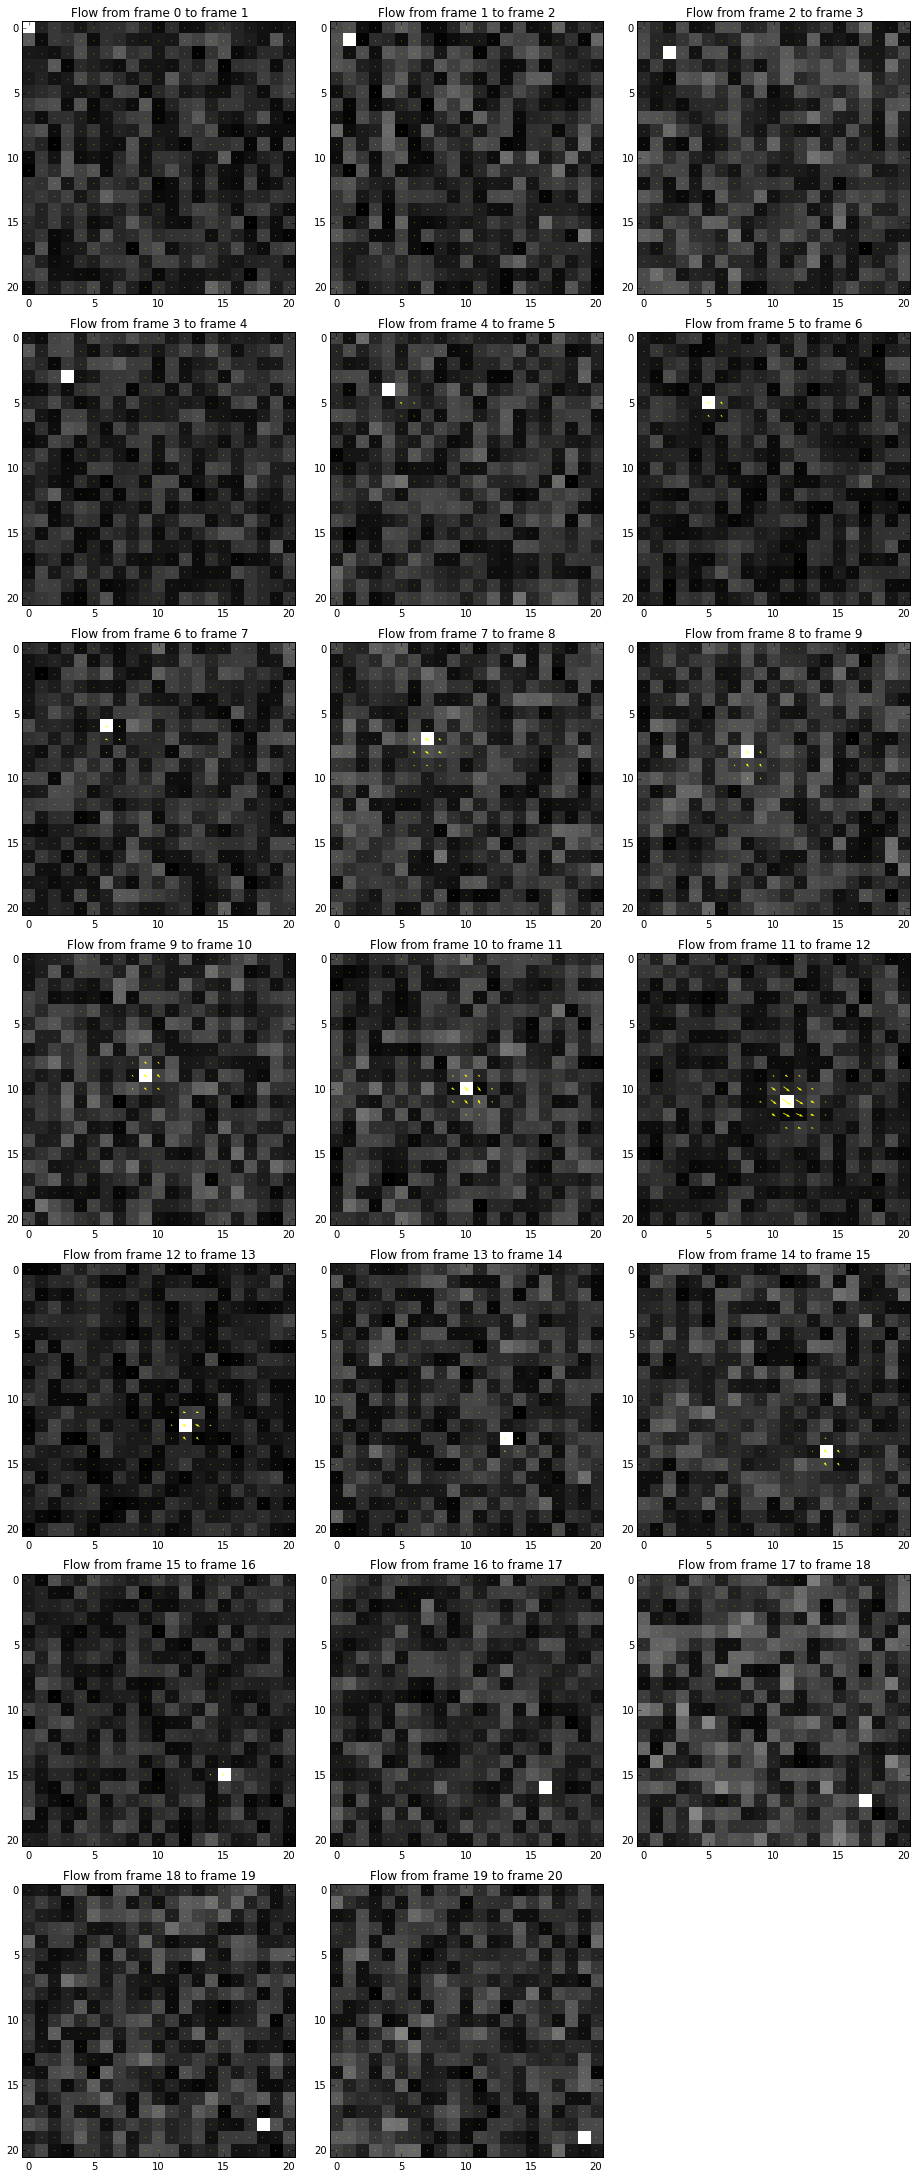

In [19]:
fy2, fx2 = calcFlow(relF)
show(relF, fx2, fy2)

In [20]:
totErr1 = error(fx, fy, fx1, fy1)

Maximum Point-wise Error =  1.0
Minimum Point-wise Error =  0.112626199342
Maximum Frobenius Norm =  20.999999946
Minimum Frobenius Norm =  20.97647932
Total Error =  20.9877985581


In [21]:
totErr2 = error(fx, fy, fx2, fy2)

Maximum Point-wise Error =  1.0
Minimum Point-wise Error =  0.27605105209
Maximum Frobenius Norm =  20.9999999999
Minimum Frobenius Norm =  20.9779933307
Total Error =  20.9919585648


In [22]:
totErr1/totErr2

0.99980182855974176

So we see the two methods continue to perform equally even in the prescence of noise. They do difer however in their magnitude approximations. Perhaps I can make to error metrics, one which looks at the error in direction and another that looks at the error in magnitude and then combine them somehow.

---
###Test 3
Here I add a spontaneous diffusive event along the diagonal, i.e., the flow path. It will take 3 frames to exist. First frame it is at half intensity, second frame at full intensity, and last frame at half intensity, then gone. I am doing this becuase we see events like this in the data, and I believe it will tamper with the relative fluorescence calculations to give some insight in how the flow is effected.

In [23]:
f,fy,fx = makeData(21, noise=3.0)
f[2,9:12,9:12] += 10.0
f[3,9:12,9:12] += 20.0
f[4,9:12,9:12] += 10.0

In [24]:
f0 = percentile(f,10,0)
relF = (f-f0)/f0

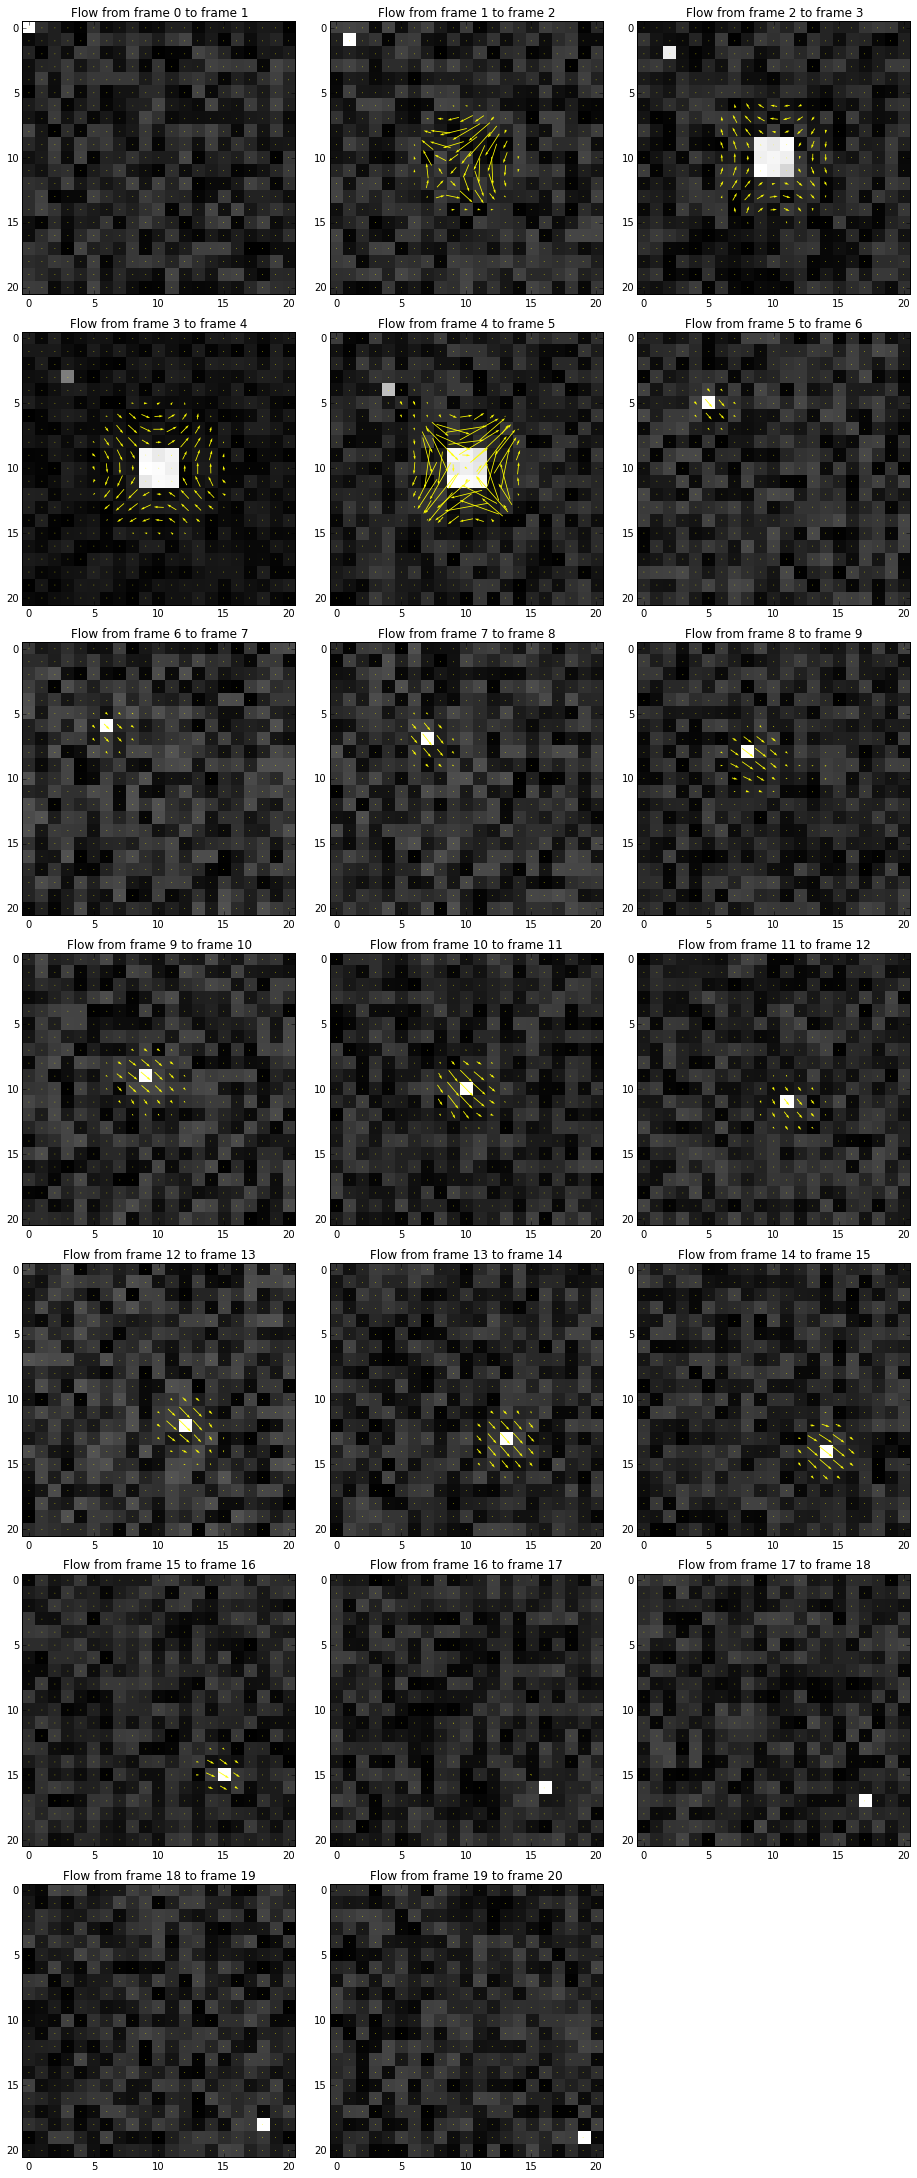

In [25]:
fy1, fx1 = calcFlow(f)
show(f, fx1, fy1)

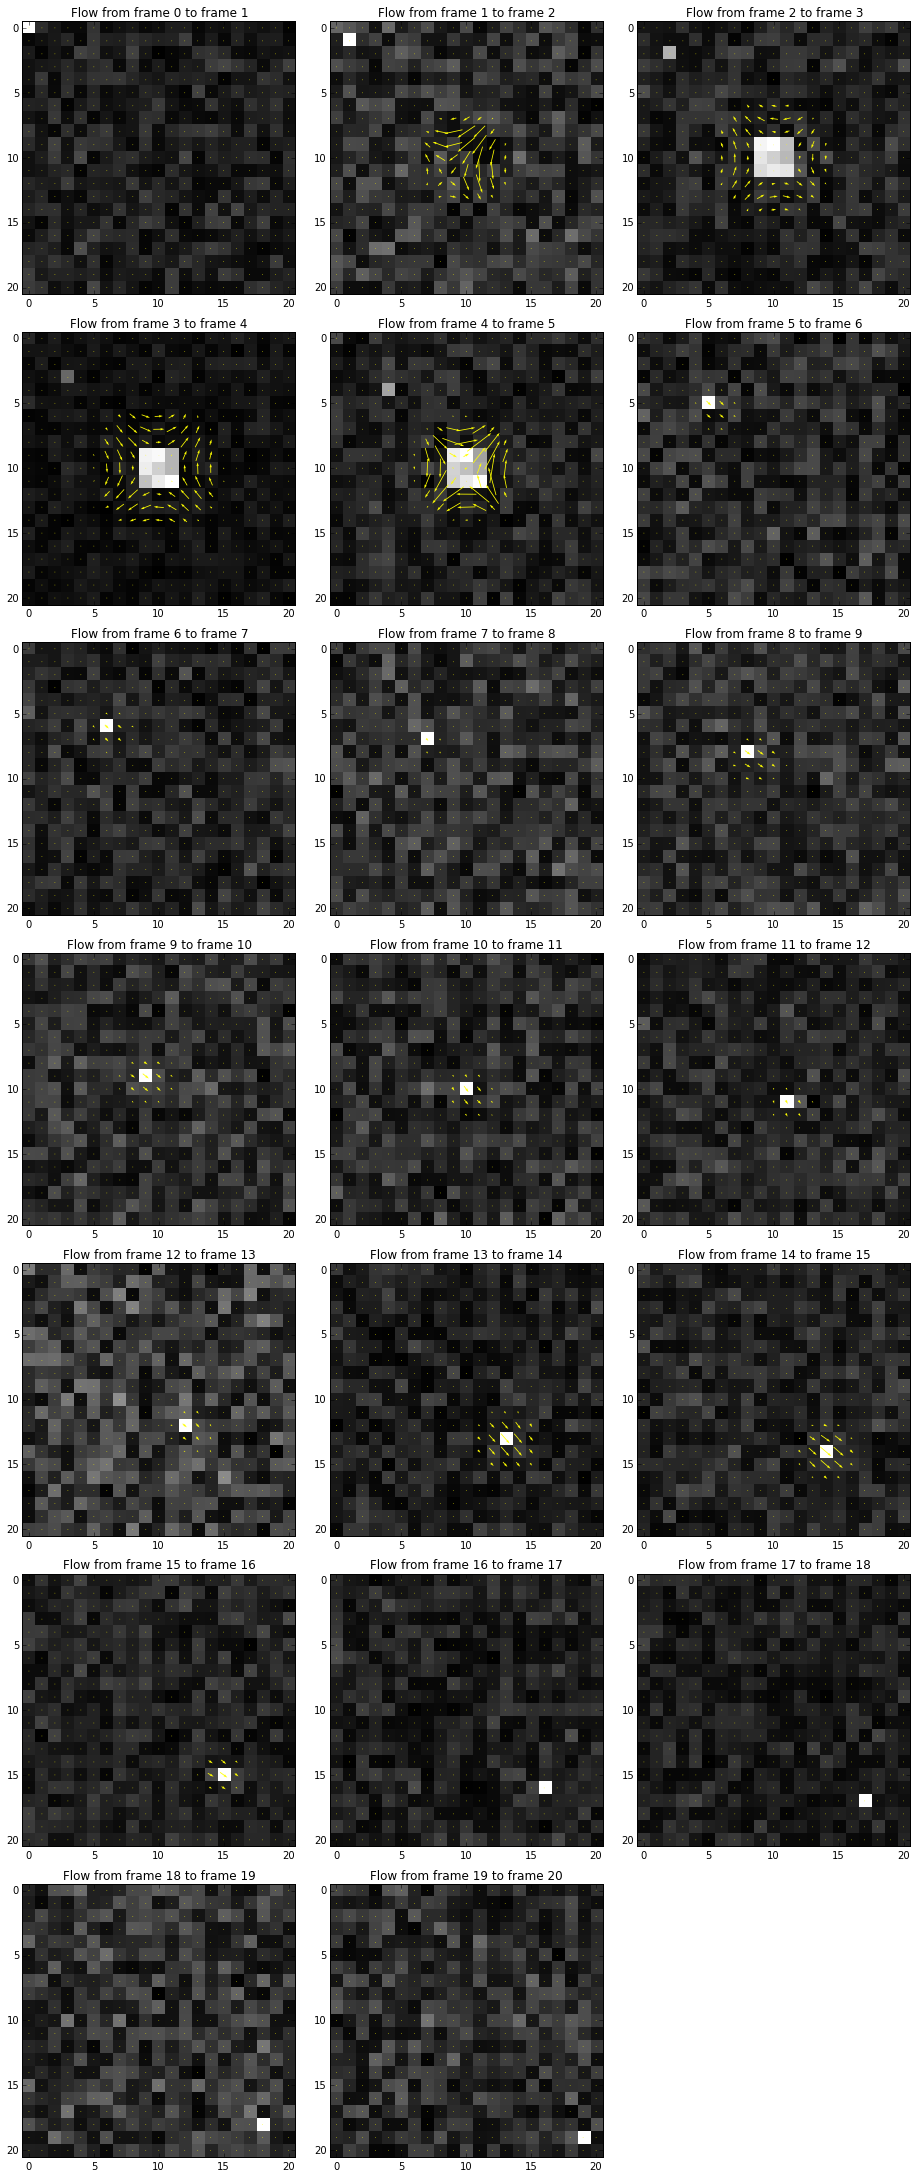

In [26]:
fy2, fx2 = calcFlow(relF)
show(relF, fx2, fy2)

In [27]:
totErr1 = error(fx,fy,fx1,fy1)

Maximum Point-wise Error =  1.0
Minimum Point-wise Error =  0.0312537600552
Maximum Frobenius Norm =  20.9999999308
Minimum Frobenius Norm =  20.9762002469
Total Error =  20.9871515999


In [28]:
totErr2 = error(fx,fy,fx2,fy2)

Maximum Point-wise Error =  1.0
Minimum Point-wise Error =  0.124625110757
Maximum Frobenius Norm =  20.9999999699
Minimum Frobenius Norm =  20.9765471758
Total Error =  20.9896430517


In [29]:
totErr1/totErr2

0.99988130089596017